In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
plt.rcParams['figure.figsize'] = [12, 5]

c1, c2 = 'GLD', 'GDX'
coin_1 = pd.read_csv('./GLD_Aug2011_May2012.csv')['Close']
coin_2 = pd.read_csv('./GDX_Aug2011_May2012.csv')['Close']
coin_3 = pd.read_csv('./SLV_Aug2011_May2012.csv')['Close']
M = 0
coin_1 = coin_1[M:M + 200]
coin_2 = coin_2[M:M + 200]
coin_3 = coin_3[M:M + 200]
dt = 1 / 252

In [17]:
def log_likelihood(parameters, S, dt):
    theta = parameters[0]
    mu = parameters[1]
    sigma = parameters[2]

    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt(sigma0)

    N = S.size

    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)
    prefactor = -1 / (2 * N * sigma0**2)

    sum_term = 0
    for i in range(1, N):
        x2 = S[i]
        x1 = S[i-1]

        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) -
                               theta * (1-np.exp(-mu*dt)))**2

    f = (term1 + term2 + prefactor * sum_term)

    return f

def calculate_parameters(x, dt):
    # Page 13

    N = x.size

    Xx = np.sum(x[0:-1])
    Xy = np.sum(x[1:])
    Xxx = np.sum(x[0:-1]**2)
    Xxy = np.sum(x[0:-1] * x[1:])
    Xyy = np.sum(x[1:]**2)

    theta0 = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy))

    mu0 = (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
        (Xxx - 2 * theta0 * Xx + N * theta0**2)
    mu0 = -1 / dt * np.log(mu0)

    prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
    term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(
        1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2 * (1-np.exp(-mu0 * dt))**2

    sigma02 = prefactor * term
    sigma0 = np.sqrt(sigma02)

    return theta0, mu0, sigma0

In [20]:
B_over_A = np.linspace(0.001, 1, 1000)
# Make this more efficient by holding value only if bigger than prev value
likelihood = []
params = []

numeric_coin_1 = pd.to_numeric(coin_1, errors='coerce')
cleaned_coin_1 = numeric_coin_1.dropna()
a1 = cleaned_coin_1.to_numpy()

numeric_coin_2 = pd.to_numeric(coin_2, errors='coerce')
cleaned_coin_2 = numeric_coin_2.dropna()
b1 = cleaned_coin_2.to_numpy()

for value in B_over_A:
    alpha = 1 / a1[0]

    beta = value / b1[0]

    X = alpha * a1 - beta * b1

    parameters = calculate_parameters(X, dt)

    likelihood.append(log_likelihood(parameters, X, dt))
    params.append(parameters)

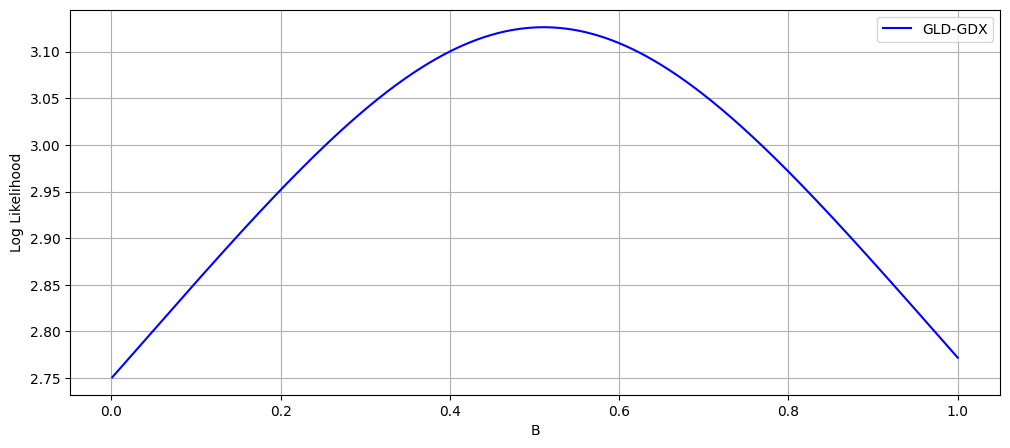

In [21]:
B = B_over_A * 1
plt.plot(B, likelihood, 'b', label=f'{c1}-{c2}')
plt.xlabel('B')
plt.ylabel('Log Likelihood')
plt.grid()
plt.legend()
plt.show()